<a href="https://colab.research.google.com/github/VissaMoutafis/Time-Series-Processing-with-Tensorflow/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import sys

sys.path.append('..')
import numpy as np
import pandas as pd

from keras import layers, optimizers, losses, metrics
from keras.models import Sequential
from keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

from sklearn.model_selection import train_test_split

from keras.layers.convolutional import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.layers import UpSampling2D
from keras import Input
import seaborn as sns
from keras.models import load_model
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt

import tensorflow as tf
	
import webbrowser

import torch

from torchtext.data.utils import get_tokenizer
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

np.random.seed(1)
torch.manual_seed(0)

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

cuda:0


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
input_dataset_path = 'drive/MyDrive/Project-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Project-Datasets/nasd_query.csv'
DATASET_SIZE = 1
LOOKBACK = 20

In [5]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()
from sklearn.model_selection import train_test_split

#train, test = train_test_split(timeseries_df, test_size=0.2)

In [6]:
mu = None
sigma = None
def normalize(dataset):
  return (dataset - mu)/sigma 

def reverse_normalize(dataset):
  return dataset*sigma + mu 

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
print(timeseries_df.to_numpy().shape)

(1, 730)


In [9]:
X_train, y_train = create_dataset(timeseries_df.to_numpy().reshape(-1),timeseries_df.to_numpy().reshape(-1),LOOKBACK)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
data_test =  list(zip(X_test,y_test))
test = pd.DataFrame(data_test)

In [10]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
y_train = y_train.reshape(-1)

X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
y_test = y_test.reshape(-1)

(475, 20, 1)
(235, 20, 1)


In [11]:
def preprocess_dataset(df, lag=1):
  global sigma
  global mu
  dataset = df.to_numpy()
  
  if sigma is None: sigma = dataset.std()
  if mu is None: mu = dataset.mean()

  dataset = normalize(dataset)
  # divide the time series in input instances of X: #lag steps y: #lag+1-th value of the time series 
  # so we acquire #df * (complexity(df)-lag)
  X = None
  y = None
  for timeseries in dataset:
    X_i = None
    y_i = None 
    for i in range(lag, len(timeseries)):
      X_ij = np.asarray(timeseries[i-lag:i]).reshape((1, len(timeseries[i-lag:i]), 1))
      X_i = np.concatenate((X_i, X_ij)) if X_i is not None else X_ij
      y_ij = np.asarray(timeseries[i]).reshape((-1, 1))
      y_i = np.concatenate((y_i, y_ij)) if y_i is not None else y_ij
    
    X = np.concatenate((X, X_i), axis=-1) if X is not None else X_i
    y = np.concatenate((y, y_i), axis=-1) if y is not None else y_i

  return train_test_split(X, y, test_size=0.2)

In [49]:
from sklearn.preprocessing import StandardScaler

class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, lstm_units, actv_fn, dropout=None, _optimizer='adam', _loss='mse'):
        super(LSTMAutoEncoder, self).__init__()
        self.history = {}
        self.D_train = None
        self.D_test = None
        self.lstm_units = lstm_units
        self.dropout = dropout
        self.optimizer = _optimizer
        self.loss = _loss
        self.input_dim = input_dim
        self.models = {}
        self.input_dim = input_dim      
        self.activation = nn.ReLU()
        self.device = device
        
        self.model = models.Sequential()
        #encoder loop
        for i, u in enumerate(self.lstm_units):
          self.model.add(BatchNormalization())
          if i == 0: 
            encoded = layers.LSTM(units=u, return_sequences=True, input_shape=self.input_dim)
            self.model.add(encoded)

          elif i == len(self.lstm_units) - 1:
            encoded = layers.LSTM(units=u)
            self.model.add(encoded)
            self.decoded = layers.RepeatVector(input_dim[0])

          else: 
            self.model.add(layers.LSTM(units=u, return_sequences=True))
          if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))

        self.model.add(self.decoded)

        #decoder loop 
        #Batch normalization not sure it helps after all...
        for i, u in enumerate(self.lstm_units[::-1]):
          self.model.add(BatchNormalization())
          if i == len(self.lstm_units) - 1:
            encoded = layers.LSTM(units=u,return_sequences=True)
            self.model.add(encoded)
          else: 
            self.model.add(layers.LSTM(units=u, return_sequences=True))
          if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))

        # final output layer
        self.model.add(layers.TimeDistributed(layers.Dense(units=input_dim[-1])))
        
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def fit(self, X_train, X_test, y_train, y_test, epochs=100, batch_size=128):
      self.D_train = X_train, y_train
      self.D_test = X_test, y_test
      self.history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    
      return self.history

In [13]:
class LSTMAutoEncoder_from_paper(nn.Module):
    def __init__(self, input_dim, lstm_units, actv_fn, dropout=None, _optimizer='adam', _loss='mse'):
        super(LSTMAutoEncoder_from_paper, self).__init__()
        self.history = {}
        self.D_train = None
        self.D_test = None
        self.lstm_units = lstm_units
        self.dropout = dropout
        self.optimizer = _optimizer
        self.loss = _loss
        self.input_dim = input_dim
        self.models = {}
        self.input_dim = input_dim      
        self.activation = nn.ReLU()
        self.device = device

        self.model = models.Sequential()
        encoded = layers.LSTM(units=64,input_shape=(input_dim[0],input_dim[-1]))
        self.model.add(encoded)
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.RepeatVector(input_dim[0]))
        self.model.add(layers.LSTM(units=64, return_sequences=True))
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.TimeDistributed(layers.Dense(units=input_dim[-1])))
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def fit(self, X_train, X_test, y_train, y_test, epochs=100, batch_size=128):
      self.D_train = X_train, y_train
      self.D_test = X_test, y_test
      self.history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    
      return self.history
        

In [50]:
#print(X_train.shape)
model1 = LSTMAutoEncoder(X_train.shape[1:],[64, 64,100],nn.ReLU,dropout=0.3)

In [15]:
model2 = LSTMAutoEncoder_from_paper(X_train.shape[1:],[50, 50,100],nn.ReLU,dropout=0.3)

In [51]:
model1.fit(X_train, X_test, y_train, y_test, epochs=50)

Epoch 1/50
4/4 [==============================] - 15s 953ms/step - loss: 349.3537 - val_loss: 348.3641
Epoch 2/50
4/4 [==============================] - 1s 239ms/step - loss: 325.4725 - val_loss: 338.2761
Epoch 3/50
4/4 [==============================] - 1s 238ms/step - loss: 295.7135 - val_loss: 319.3885
Epoch 4/50
4/4 [==============================] - 1s 246ms/step - loss: 268.1435 - val_loss: 295.5633
Epoch 5/50
4/4 [==============================] - 1s 249ms/step - loss: 243.1853 - val_loss: 271.7318
Epoch 6/50
4/4 [==============================] - 1s 247ms/step - loss: 222.2837 - val_loss: 250.7403
Epoch 7/50
4/4 [==============================] - 1s 248ms/step - loss: 204.7799 - val_loss: 232.7684
Epoch 8/50
4/4 [==============================] - 1s 252ms/step - loss: 188.9501 - val_loss: 216.9285
Epoch 9/50
4/4 [==============================] - 1s 246ms/step - loss: 174.7386 - val_loss: 201.6969
Epoch 10/50
4/4 [==============================] - 1s 244ms/step - loss: 161.6257

In [17]:
model2.fit(X_train, X_test, y_train, y_test, epochs=50)

Epoch 1/50
4/4 [==============================] - 4s 314ms/step - loss: 345.5441 - val_loss: 307.6190
Epoch 2/50
4/4 [==============================] - 0s 57ms/step - loss: 298.3935 - val_loss: 262.5174
Epoch 3/50
4/4 [==============================] - 0s 59ms/step - loss: 256.1076 - val_loss: 225.5454
Epoch 4/50
4/4 [==============================] - 0s 59ms/step - loss: 221.2982 - val_loss: 195.1886
Epoch 5/50
4/4 [==============================] - 0s 57ms/step - loss: 190.3277 - val_loss: 167.6632
Epoch 6/50
4/4 [==============================] - 0s 58ms/step - loss: 163.1028 - val_loss: 141.7625
Epoch 7/50
4/4 [==============================] - 0s 57ms/step - loss: 137.9259 - val_loss: 119.0427
Epoch 8/50
4/4 [==============================] - 0s 60ms/step - loss: 116.1010 - val_loss: 100.6152
Epoch 9/50
4/4 [==============================] - 0s 57ms/step - loss: 99.0858 - val_loss: 86.1622
Epoch 10/50
4/4 [==============================] - 0s 57ms/step - loss: 85.7124 - val_loss: 

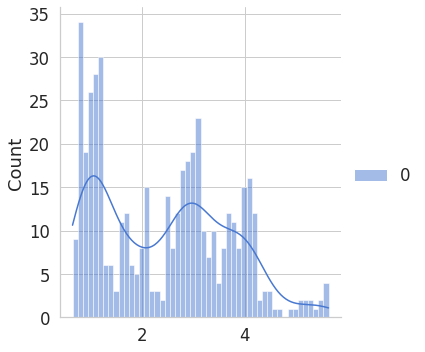

In [52]:
import seaborn as sns
X_train_pred = model1.model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True);

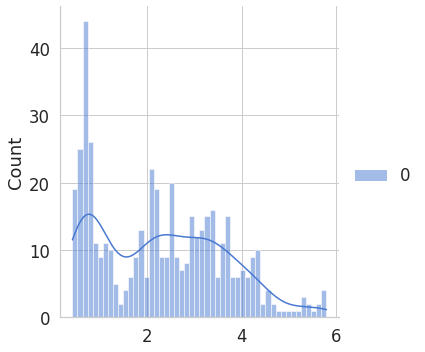

In [19]:
import seaborn as sns
X_train_pred = model2.model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True);

In [53]:
def plot_anomalies(model,X_train, X_test, y_train, y_test):
  X_test_pred = model.model.predict(X_test)
  test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
  THRESHOLD = 5
  test_score_df = pd.DataFrame()#pd.DataFrame(test_mae_loss, index=[i[0] for i in test_mae_loss])
  test_score_df['loss'] = test_mae_loss.flatten()
  test_score_df['threshold'] = THRESHOLD
  test_score_df['anomaly'] = test_score_df.loss > THRESHOLD
  test_score_df['close'] = X_test[:,1]
  #check if we are tresholding right
  #plt.plot(test_score_df.index, test_score_df.loss, label='loss')
  #plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
  #plt.xticks(rotation=25)
  #plt.legend();

  #scaler = StandardScaler()
  #scaler = scaler.fit(X_train[:,1])
  counter = 0
  #for i in test_score_df['loss']:
  #  if i > THRESHOLD:
  #    print(i)
  #    counter += 1
  #print(counter)    
  anomalies = test_score_df[test_score_df.anomaly == True]
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.plot(
    test_score_df.index, 
    X_test[:,1], 
    label='close price'
  );
  #plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
  sns.scatterplot(anomalies.index,anomalies.close,color=sns.color_palette()[3],s=52,label='anomaly')
  plt.xticks(rotation=25)
  plt.legend();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


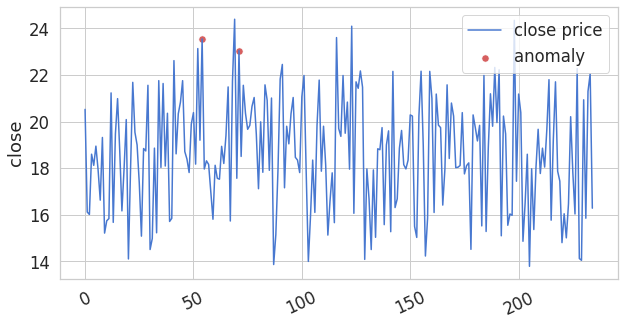

In [54]:
plot_anomalies(model1,X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


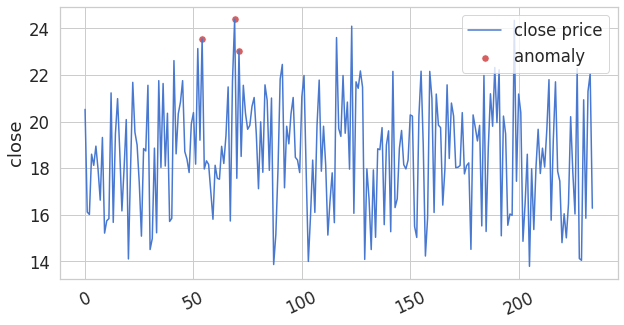

In [22]:
plot_anomalies(model2,X_train, X_test, y_train, y_test)

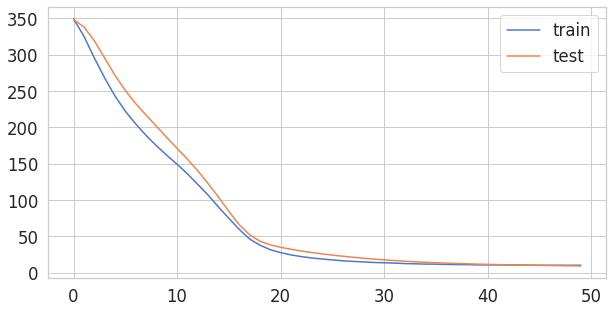

In [55]:
plt.plot(model1.history.history['loss'], label='train')
plt.plot(model1.history.history['val_loss'], label='test')
plt.legend()

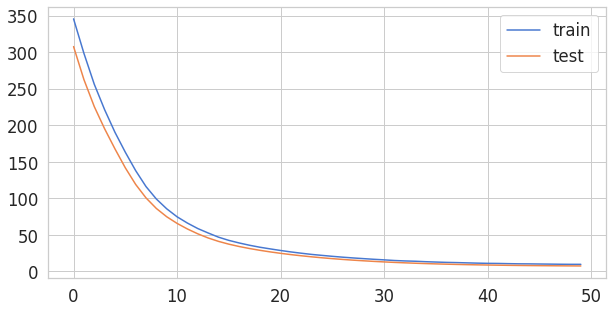

In [24]:
plt.plot(model2.history.history['loss'], label='train')
plt.plot(model2.history.history['val_loss'], label='test')
plt.legend()